# Классификация изображений с эмоциями людей

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

print("TensorFlow Version:", tf.__version__)
print("TensorFlow Hub Version: ", hub.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.8.3
TensorFlow Hub Version:  0.12.0
GPU Device Not Found. Running on CPU


# <b>Подготовка файлов для работы с локального диска</b>

## Загрузка данных на локальный диск

In [2]:
import gdown
import zipfile
from pathlib import Path

# Загрузка архива
# stable link https://drive.google.com/file/d/1uVFqpd7PL-ePgszJFDriaiveuhIi-InF
ident = '1uVFqpd7PL-ePgszJFDriaiveuhIi-InF'
fname = 'emotions'

# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

local_zip = gdown.download(id=ident, output = fname + '.zip')

Downloading...
From: https://drive.google.com/uc?id=1uVFqpd7PL-ePgszJFDriaiveuhIi-InF
To: C:\Users\Red_Plague\YandexDisk\code_learning\DS_Sber\Профильный_модуль\SBER_Diploma\emotions.zip
100%|█████████████████████████████████████| 86.5M/86.5M [00:20<00:00, 4.21MB/s]


Распаковка в текущую директорию.

In [3]:
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(p)

Переименуем папку с изображениями в `emotions`.

Для отключения ограничения "Только чтение" у папки с изображениями воспользуемся следующей функцией ([источник](https://www.tutorialspoint.com/How-to-change-the-permission-of-a-directory-using-Python#)):

In [4]:
def change_permissions_recursive(path, mode):
    for root, dirs, files in os.walk(path, topdown=False):
        for dr in [os.path.join(root,d) for d in dirs]:
            os.chmod(dr, mode)
        for file in [os.path.join(root, f) for f in files]:
                os.chmod(file, mode)

In [5]:
import os

zip_content = os.listdir(p)[0]
zip_content

'FEELINGS 3000'

Функция не всегда срабатывает с первого раза, поэтому запустим следующий цикл:

In [6]:
done = False

while done == False:
    try:
        change_permissions_recursive(p, 0o777)
        change_permissions_recursive(p / zip_content, 0o777)
        zip_content = os.renames(p / zip_content,
                   base_dir)
        done = True
    except:
        continue

Теперь загруженный архив можно удалить.

In [7]:
os.remove(fname + '.zip')

## Настройка и проверка директорий

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями этих папок и их количество. 

In [48]:
from pathlib import Path

# # Базовая директория
import os
fname = 'emotions'
base_dir = Path('./data') / fname
# # base_dir = '/content/drive/MyDrive/Sber DS/Diploma/data/emotions/'  # for colab
classes = os.listdir(base_dir)

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['ANGER', 'DISGUST', 'FEAR', 'JOYFULNESS', 'NEUTRAL']
Количество классов: 5


Переименуем папки в необходимые нам названия классов:

In [49]:
class_names = [x.lower() for x in classes]
    
done = False
while done == False:
    try:
        change_permissions_recursive(base_dir, 0o777)
        done = True
    except:
        continue

done = False
while done == False:
    try:
        for i, class_name in enumerate(class_names):
            change_permissions_recursive(base_dir/class_name, 0o777)
            os.renames(base_dir/classes[i], base_dir/class_name)
        done = True
    except:
        continue

classes = os.listdir(base_dir)

In [50]:
classes

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']

## Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник](https://github.com/tensorflow/datasets/issues/2188)).

In [51]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir / f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [52]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

anger
disgust
[ERR] data\emotions\disgust\5a971597aae6052a008b45a7.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] data\emotions\disgust\gettyimages-520925691.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] data\emotions\disgust\Universal_Expression_Disgust.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
fear
joyfulness
neutral


Битых файлов нет, можно двигаться дальше.

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [53]:
anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir = [base_dir / classes[i]
                                                   for i in range(len(classes))]
directories = anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir


anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames = [os.listdir(i)
                                                              for i in directories]
files_names = anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames


for i, cls_name in enumerate(class_names):
    print(cls_name + ':', len(files_names[i]))

anger: 174
disgust: 292
fear: 177
joyfulness: 339
neutral: 398


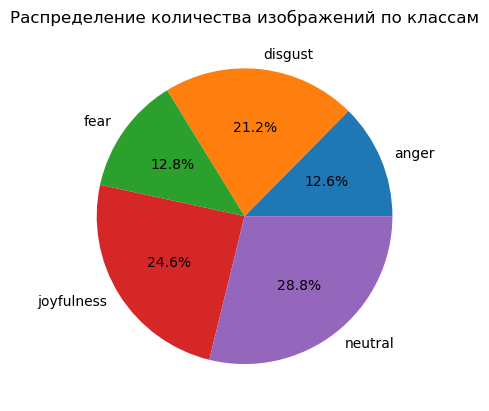

In [54]:
import seaborn as sns

x = np.array([len(anger_fnames), len(disgust_fnames),
              len(fear_fnames), len(joyfulness_fnames),
              len(neutral_fnames)])

plt.title('Распределение количества изображений по классам')
plt.pie(x, labels=classes, autopct='%.1f%%');

Классы несбалансированы, поэтому, помимо метрики `accuracy`, для оценки ошибки классификации мы будем использовать матрицу ошибок. 

Посмотрим на названия отдельных файлов.

In [55]:
for i in files_names:
    print(i[90:93])

['278101.jpg', '280.jpg', '28185.jpg']
['199642.jpg', '200122272-003.jpg', '203679.jpg']
['221981.jpg', '225180.jpg', '227900.jpg']
['16932.jpg', '16936.jpg', '171.jpg']
['1544.jpg', '15494.jpg', '156106.jpg']


## Визуализация оригинальных изображений

Посмотрим на восемь фотографий из обеих субдиректорий - 4 фотографии с выжженной территорией и 4 с обычной.

In [56]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 5
ncols = 4

# Index for iterating over images
pic_index = 0

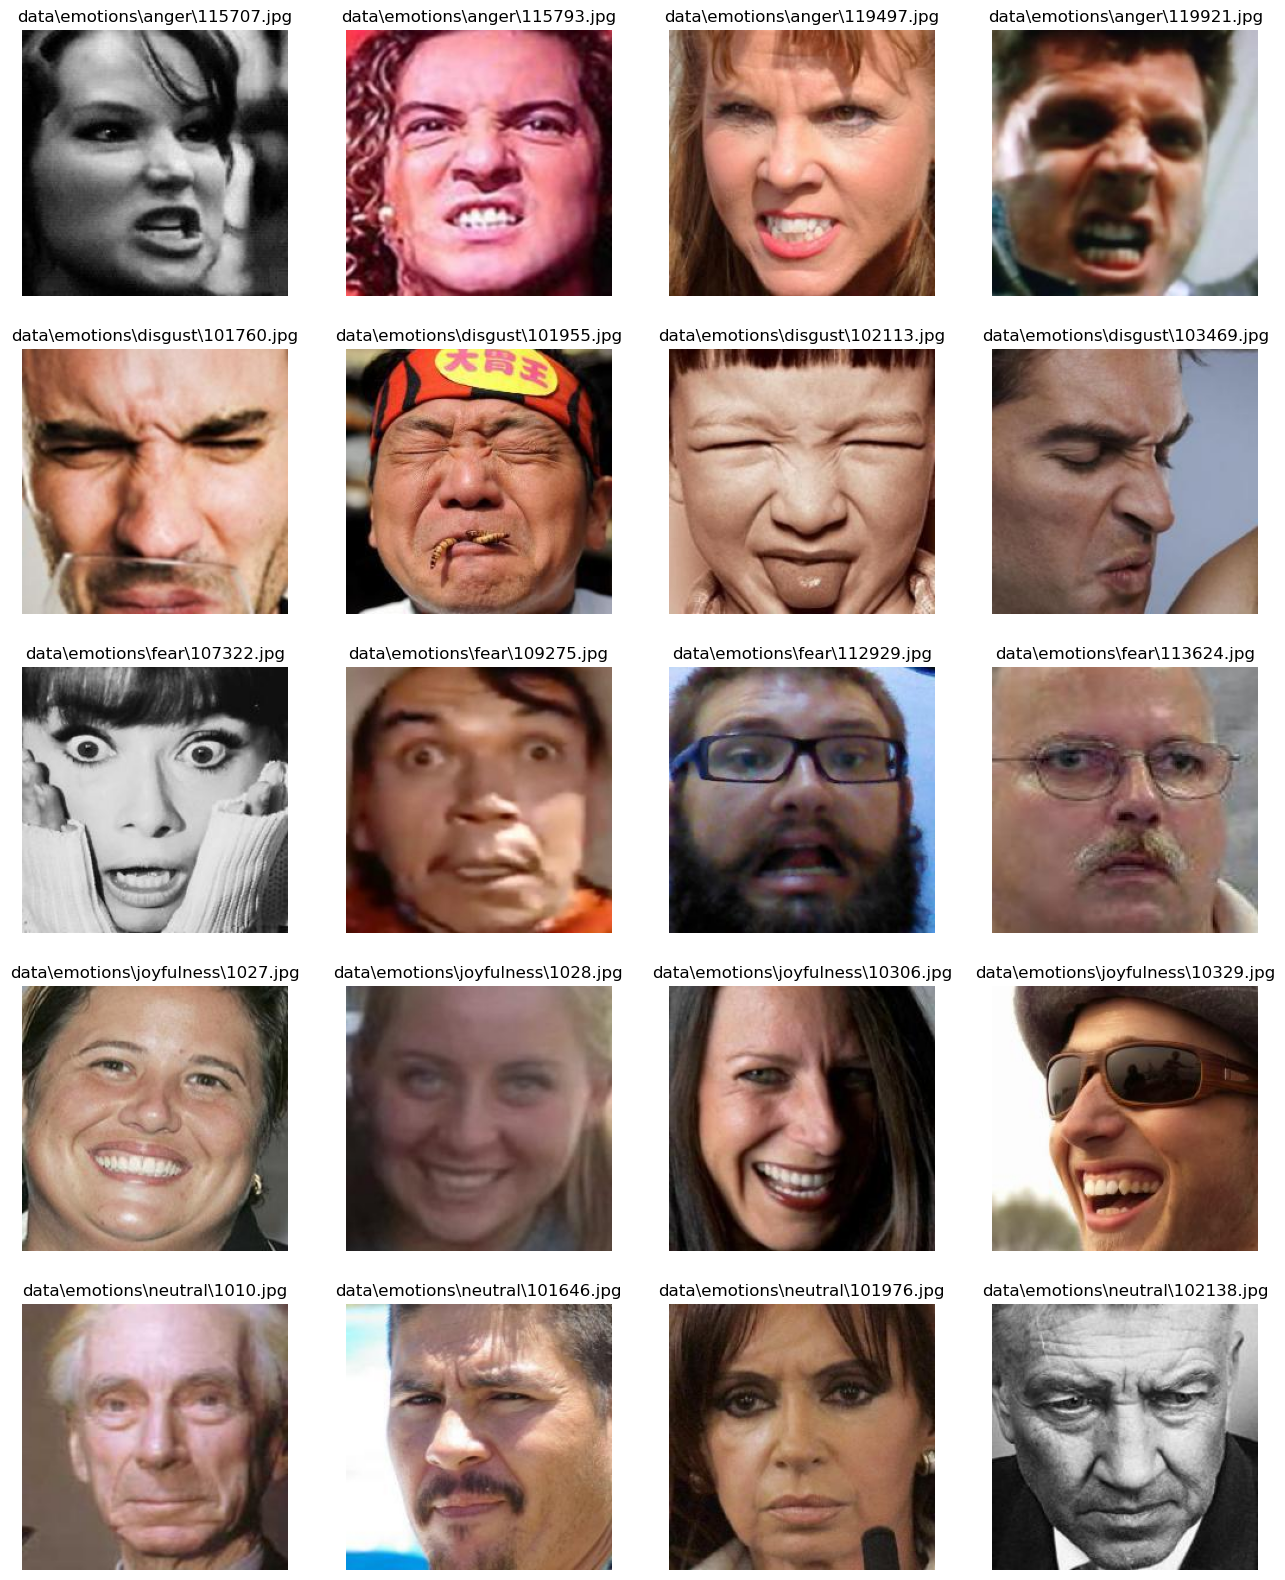

In [58]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 4

next_anger_pic = [os.path.join(anger_dir, fname)
                for fname in anger_fnames[pic_index-4:pic_index]]
next_disgust_pic = [os.path.join(disgust_dir, fname)
                for fname in disgust_fnames[pic_index-4:pic_index]]
next_fear_pic = [os.path.join(fear_dir, fname)
                for fname in fear_fnames[pic_index-4:pic_index]]
next_joyfulness_pic = [os.path.join(joyfulness_dir, fname)
                for fname in joyfulness_fnames[pic_index-4:pic_index]]
next_neutral_pic = [os.path.join(neutral_dir, fname)
                for fname in neutral_fnames[pic_index-4:pic_index]]


for i, img_path in enumerate(next_anger_pic+next_disgust_pic+
                            next_fear_pic+next_joyfulness_pic+
                            next_neutral_pic):
    # Set up subplot; subplot indices start at 1
    ax = plt.subplot(nrows, ncols, i+1)
    # Отключить оси
    ax.axis(False)
    plt.title(img_path)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и и соотношение сторон, поэтому их необходимо привести к единому стандарту на стадии формирования датасетов для нейронной сети. Этим мы сейчас и займемся.

## Split вручную

Так как готовых инструментов для формирования датасета из трех частей (тренировка, валидация, тест) в tensorflow нет, предварительно необходимо разделить все изображения на соответствующие директории, внутри которых будут папки с классами.

Напишем собственную функцию, которая переместит все изображения по нужным нам папкам, создав, таким образом, необходимое разделение данных на три датасета. Функция содержит вложенную функцию `split_numbers`, которая автоматически определит количество изображений, необходимое для каждого сплита по всем классам в соотношении: `train : validation : test = 8:1:1`. При желании основную и вложенную функции можно дописать так, чтобы желаемое соотношение можно было задавать при каждом запуске пограммы, но мы не планируем изменять это соотношение, поэтому зафиксировали данные числа внутри функции.  

In [59]:
from pathlib import Path
import shutil
import os

def make_split(files_names, base_dir, class_folder, relation=(8, 1, 1)):
    
    dataset_split_folders = 'train', 'validation', 'test'
    train_dir, val_dir, test_dir = [base_dir / i
                    for i in dataset_split_folders]

    for directory in (train_dir, val_dir, test_dir):
        try:
            Path.mkdir(directory)
        except:
            # print(f'Directory {directory} already exists or cannot be created.')
            pass
        try:
            Path.mkdir(directory / class_folder)
        except:
            # print(f'Directory {directory / class_folder} already exists or cannot be created.')
            pass

    def split_numbers(files_names=files_names):
        imgs_num = len(files_names)
        train_num, val_num = int(imgs_num/10*relation[0]), int(imgs_num/10*relation[1])
        test_num = imgs_num - train_num - val_num
        return train_num, val_num, test_num
        
    examples = split_numbers(files_names)
    directories = train_dir, val_dir, test_dir

    for num, dr in zip(examples, directories):
        i = num
        while i != 0:
            image_name = os.listdir(base_dir / class_folder)[i-1]
            shutil.move(base_dir / class_folder / image_name,
                         dr / class_folder / image_name)
            i -= 1

    shutil.rmtree(base_dir / class_folder)

Применим эту функцию к каждому из классов.

In [60]:
for i in range(len(classes)):
    make_split(files_names[i],
             base_dir=base_dir,
             class_folder=classes[i])

Наш датасет разделен на три части в соотношении 8:1:1. Теперь у нас имеются три директории, содержащие папки с нужными нам классами.

In [61]:
for i in os.listdir(base_dir):
    print(i, os.listdir(base_dir / i))

test ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
train ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
validation ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


# <b>Создание датасетов под данную предобученную модель</b>

## Гиперпараметры для модели с переносом обучения

В самом начале обозначим гиперпараметры для будущей модели, это позволит нам уже сейчас начать подготавливать необходимые команды с этими данными для дальнейшего использования. Также определим, какую предобученную модель мы будем использовать для нашей модель.

- "mobilenet_v2", 224, 1280  
или
- "inception_v3", 299, 2048.

In [62]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE =f"https://tfhub.dev/google/tf2-preview/{handle_base}/feature_vector/4"
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32
print("Using {} with input size {} and output dimension {}".format(
                                        MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Подготовка датасетов

Для обучения модели и затем конвертации ее в облегченную версию все предварительно разделенные по папкам изображения необходимо перевести в формат `dataset`. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`.

Для корректной работы кода, создающего облегченную версию нашей модели, который мы позаимствовали из курса по компьютерному зрению, тренировочный и валидационный датасеты должны иметь достаточно большой батч, тогда как тестовый датасет должен выдавать по одному изображению зараз, то есть батч должен равняться 1. 

Весь необходимый код оформим в функцию, которая и проделает все операции.

In [63]:
from pathlib import Path

def datasets_prep(base_directory=base_dir,
                  seed=123,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='categorical'):
    
    train_dir = base_dir / 'train'
    val_dir = base_dir / 'validation'
    test_dir = base_dir / 'test'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            train_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            val_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
                            test_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=1)  # установим батч = 1
    
    return train_ds, val_ds, test_ds

In [64]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 1102 files belonging to 5 classes.
Found 204 files belonging to 5 classes.
Found 74 files belonging to 5 classes.


Проверим созданные датасеты на соответствие заданным выше параметрам.

In [65]:
for ds in (train_batches, validation_batches, test_batches):
    for image_batch, label_batch in ds.take(1):
        print(image_batch.shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(1, 224, 224, 3)


Как и требовалось, тренировочный и валидационный датасеты содержат по 32 изображения в батче, тестовый - 1.

Проверим классы, верно ли отработал данный инструмент.

In [66]:
for ds in (train_batches, validation_batches, test_batches):
    print(ds.class_names)
    
class_names = train_batches.class_names
num_classes = len(class_names)

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


## Визуализация изображений из `train_batches`

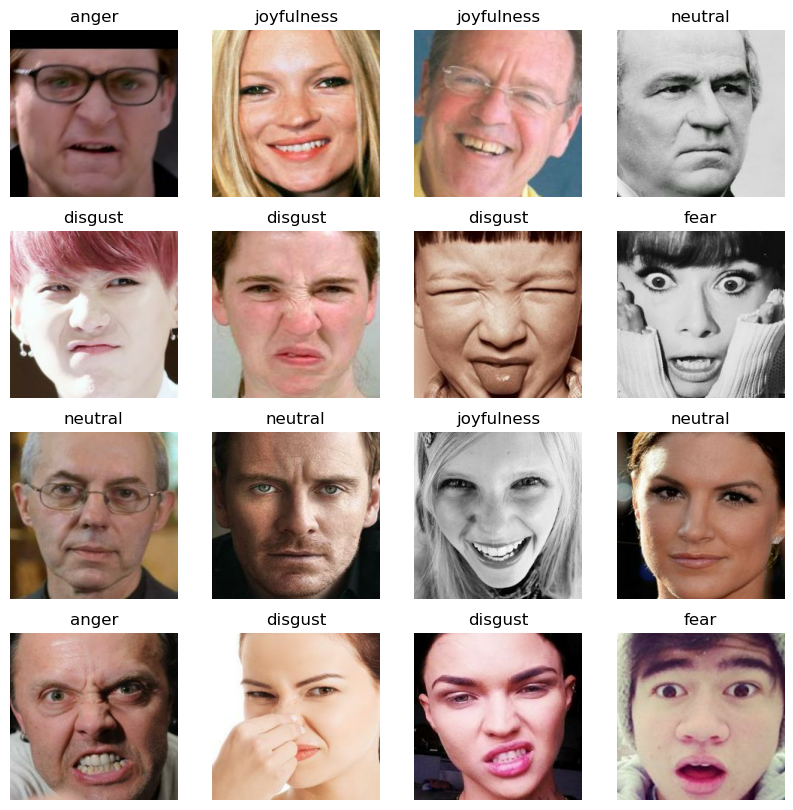

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        category_class = int(tf.argmax(labels[i]))
        plt.title(class_names[category_class])
        plt.axis('off')

Также возьмем одно из изображений из получившегося датасета и посмотрим, получили ли мы желаемое разрешение. Это изображение пригодится нам в дальнейшм, поэтому сохраним его в переменную `one_pic`.

(224, 224, 3)


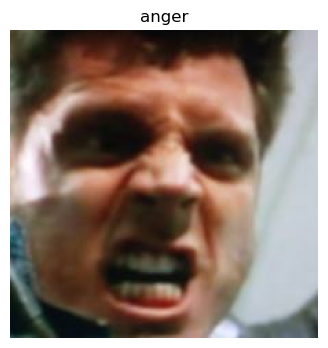

In [77]:
# одно случайное изображение
for images, labels in train_batches.take(1):
    one_pic = images[1].numpy()
    label = labels[1]
    break
    
label

print(one_pic.shape)
plt.figure(figsize=(4, 4))
plt.title(class_names[int(tf.argmax(label))])
plt.axis('off')
plt.imshow(one_pic.astype('uint8'));

# <b>Подготовка слоев для изображений</b>

## Аугментация данных

Следующий шаг - аугментация данных. Так как наш датасет создан из сравнительно небольшого набора данных, а именно из нарезанных спутниковых снимков, то для избежания переобучения мы воспользуемся возможностями библиотеки `keras` по искусственному расширению количества фотографий через внешнее изменение имеющихся. Создадим последовательность слоев `RandomFlip` (зеркальное отображение изображения в случайном порядке), `RandomRotation` (поворот изображения по часовой стрелке на случайный угол), `RandomZoom` (увеличение и уменьшение изображения в случайном порядке), а также `RandomContrast`. Это не все воможности аугментации, представленные в библиотеке `TensorFlow`, но на данном этапе мы остановимся на этих методах.

### Создание последовательности для агументации данных

In [ ]:
import tensorflow as tf

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical', name='RandomFlip'),
    tf.keras.layers.RandomRotation(factor=1, fill_mode='reflect',
                                   name='RandomRotation'),
    tf.keras.layers.RandomZoom(height_factor=(-0.3, 0.1), name='RandomZoom'),
    tf.keras.layers.RandomContrast(factor=(0.3, 1), name='RandomContrast')
])

KeyboardInterrupt: 

### Визуалиация работы слоя `data_augmentation`

Как и в случае с созданием датасета, проверим на уже использованном изображении из тренировочного датасета, как работает последовательность по аугментации данных. Если следующий блок с кодом запустить несколько раз, то мы увидим, как меняется изображение, проходя через вышеописанные слои.

> _**Note**: В версии tf 2.11.0 при выполнении нижеследующего кода выводятся предупреждения, которые не влияют на качество работы модели._

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


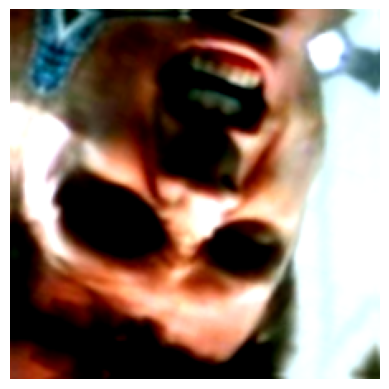

In [135]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через последовательность слоев
result_for_aug = np.expand_dims(result, axis=0)
augmented = data_aug(result_for_aug)
print(augmented.shape)

plt.axis('off')

# вернем результату размерность 3 для отображения
# plt.imshow(augmented.reshape(result.shape));
plt.imshow(np.squeeze(augmented));

## Rescale

Создадим слой для будущей модели, который приведет значения массивов изображений к стандартному виду (от 0 до 1). Это стандартная операция по подготовке изображений для обучения нейросети. Так как даный слой будет первым в нашей сети, укажем `input_shape=IMAGE_SIZE+(3,)`.

In [78]:
rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255,
                              input_shape=IMAGE_SIZE+(3,),
                              name='Rescaling')
])

Проверим качество работы слоя на фотографии, которую мы использовали выше.

Минимальное и максимальное значение пикселей: 0.0 1.0


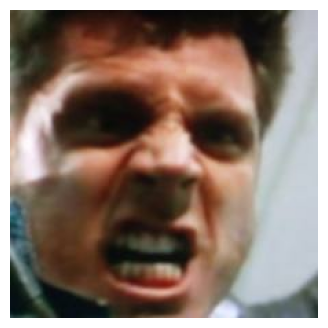

In [79]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через слой
result = rescale(np.expand_dims(one_pic, axis=0))

# вернем результату размерность 3 для отображения
result = np.squeeze(result)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(result)

# print("Picture's shape:", result.shape)
print("Минимальное и максимальное значение пикселей:", result.min(), result.max())

Как видим, слой отработал ожидаемым образом, значения пикселей приведены к диапазону от 0 до 1.

Итак, датасет для модели создан, все фотографии приведены к единому разрешению, можно переходить к обработке данных для тренировки модели. Обработка данных для нашей модели состоит из двух частей: нормализация значений массива (`rescale`) и агументация данных. Подготовим обе части и запустим две модели - без ааугментации и с ней, чтобы посмотреть, как этот блок слоев влияет на работу модели. 

## Оптимизация работы кэша

Оптимизируем работу кэша следующим кодом:

In [136]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

# <b>Модель 1</b> | Baseline

## Модуль Hub | `feature_extractor_layer`

Создадим `feature_extractor`, который извлечет веса из предобученной модели `tensorflow` для переноса обучения на нашу модель.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [137]:
do_fine_tuning = False

In [138]:
feature_extractor = hub.KerasLayer(
                            MODULE_HANDLE,
                            input_shape=IMAGE_SIZE + (3,),
                            output_shape=[FV_SIZE],
                            trainable=do_fine_tuning
)

## Архитектура модели

In [140]:
print('Building model with', MODULE_HANDLE)

model_1 = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_1.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [141]:
if do_fine_tuning:
    model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model_1.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## Обучение модели

In [142]:
EPOCHS = 2

hist_1 = model_1.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/2
35/35 [==============================] - 68s 2s/step - loss: 1.8225 - accuracy: 0.2477 - val_loss: 1.6419 - val_accuracy: 0.2598
Epoch 2/2
35/35 [==============================] - 54s 2s/step - loss: 1.6454 - accuracy: 0.3285 - val_loss: 1.5847 - val_accuracy: 0.2892


## Визуализация данных по работе алгоритма

Посмотрим на то, как вели себя функция потерь и `accuracy` на тренировочном и валидационном датасетах на всех итерациях нашей модели. Напишем функцию, которая нам пригодится и в дальнейшем.

In [143]:
def val_acc_viz(history, epochs):    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, EPOCHS+1)

    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy')
    plt.xlabel('epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.show()

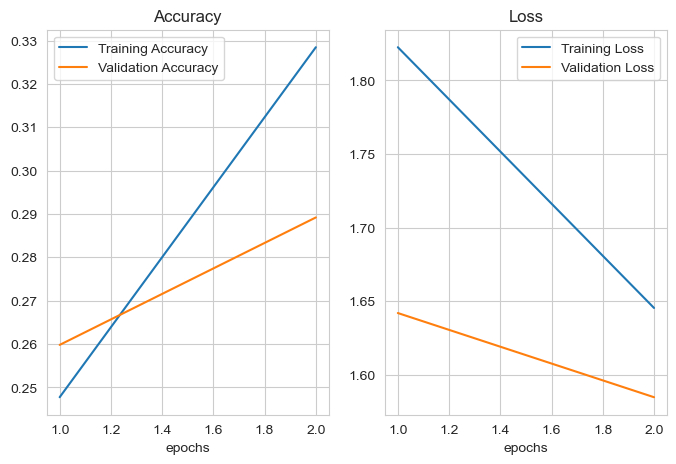

In [144]:
val_acc_viz(hist_1, EPOCHS)

## Предсказание модели

### На изображениях из Сети

При желании качество работы модели можно проверить на реальных фотографиях экспертным методом. Для этого создадим новую папку, куда загрузим желаемые изображения. Далее, подготовленная функция преобразует изображения в необходимый для визуализации и предсказания формат. Оставим эту часть в качестве дополнения, использовать ее пока не будем.

In [ ]:
# from PIL import Image
# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# new_test_dir = Path('./data/test_images')
# Path.mkdir(new_test_dir)

# def show_predictions(model):
    
#     images = os.listdir(new_test_dir)
    
#     for i, img_path in enumerate(images):

#         # путь к тестовым изображениям
#         path = new_test_dir / img_path

#         # приведение изображений к желаемому разрешению
#         img = load_img(path, target_size=IMAGE_SIZE + (3,))
#         # перевод изображения в массив
#         x = img_to_array(img)

#         # добавление четвертого измерения для модели
#         images = np.expand_dims(x, axis=0)
        
#         plt.figure(figsize=(2, 2))
#         # Отключить оси
#         plt.axis(False)
#         plt.imshow(np.squeeze(images).astype('uint8'))
#         # plt.title(img_path)
#         plt.show()

#         # предсказание
#         classes = model.predict(images, batch_size=10)

#         class_pred = np.argmax(classes)
#         # print(np.argmax(class_pred))
#         print(f'{img_path} is {class_names[class_pred]} ({np.max(classes[0])*100:.2f}%)')
        
# show_predictions(model)

### На изображениях из тестовой выборки

Посмотрим на то, как модель предсказывает тестовые изображения, хранящиеся в третьей, тестовой выборке, которая до этого момента не принимала участия в работе. Напомним, что тестовая выбора разбита на батчи по одному изображению, что позволяет нам проще контролировать количество изображений, которое мы хотим использовать для предсказания. Следующая функция покажет изображение, заданное и предсказанное значение класса, а также "уверенность" модели в своем предсказании. На данном этапе посмотрим на небольшое количество изображений (по умолчанию 10, можно изменить это число, задав соответствующий аргумент), а полную картину оценим дальше, построив матрицу ошибок.

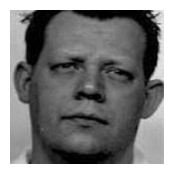

neutral is fear (51.84%)


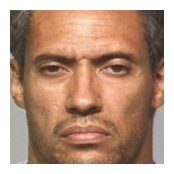

neutral is joyfulness (38.69%)


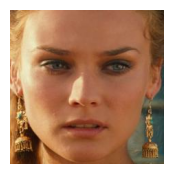

neutral is neutral (34.43%)


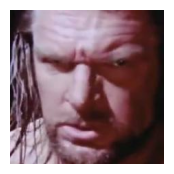

anger is neutral (28.45%)


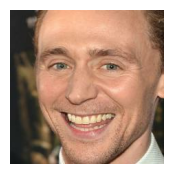

joyfulness is neutral (43.58%)


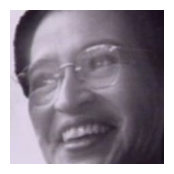

joyfulness is neutral (43.87%)


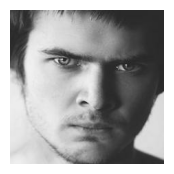

anger is joyfulness (26.36%)


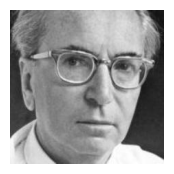

neutral is joyfulness (35.60%)


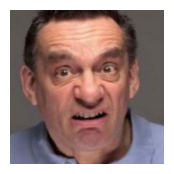

disgust is neutral (52.10%)


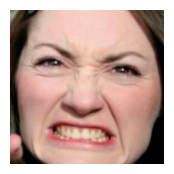

anger is neutral (36.26%)


In [149]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, images_number=10):
    
    images = test_batches.take(images_number)
        
    for img, label in images:
        
        plt.figure(figsize=(2, 2))
        # Отключить оси
        plt.axis(False)
        # оставим три измерения из четырех
        image = np.squeeze(img)
        plt.imshow(image.astype('uint8'))
        plt.show()

        # реальный класс
        label = np.argmax(label)
        
        # предсказанный класс
        prediction = model.predict(img)

        pred = np.argmax(prediction)
        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')
        
show_predictions(model_1)

## Матрица ошибок

Напишем функцию для отображения матрицы ошибок, которая пригодится нам и в дальнейшем.

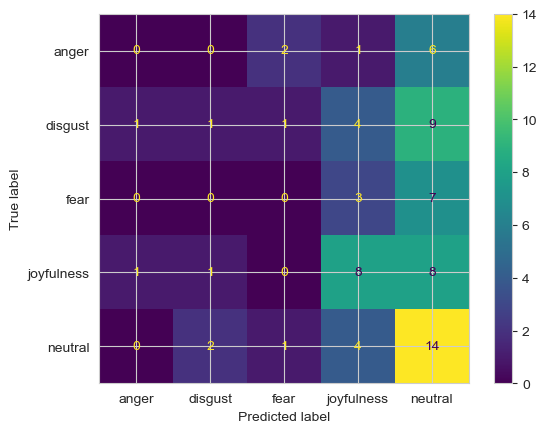

In [150]:
def confusion_matrix(model, images_number=None, dataset=test_batches, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - images_number - количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке.
    - dataset - tf.dataset с тестовыми изображениями.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)
        
    y_test, y_pred = ([np.argmax(y) for _, y in test_images], 
                      [np.argmax(x) for x in model.predict(test_images)])
        
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
    
confusion_matrix(model_1)

# <b>Модель 2</b> | `fine_tuning`

## Модуль Hub | `feature_extractor_layer`

На этот раз попробуем обучить модель с 

In [240]:
do_fine_tuning = True

In [241]:
feature_extractor = hub.KerasLayer(
                            MODULE_HANDLE,
                            input_shape=IMAGE_SIZE + (3,),
                            output_shape=[FV_SIZE],
                            trainable=do_fine_tuning
)

In [242]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(feature_extractor.layers))

AttributeError: 'KerasLayer' object has no attribute 'layers'

In [239]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in feature_extractor.layers[:fine_tune_at]:
    layer.trainable = False

AttributeError: 'KerasLayer' object has no attribute 'layers'

## Архитектура модели

In [153]:
print('Building model with', MODULE_HANDLE)

model_2 = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_2.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


In [154]:
if do_fine_tuning:
    model_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model_2.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## Обучение модели

In [155]:
EPOCHS = 2

hist_2 = model_2.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/2
 4/35 [==>...........................] - ETA: 5:01 - loss: 1.8948 - accuracy: 0.2656

KeyboardInterrupt: 

## Визуализация данных по работе алгоритма

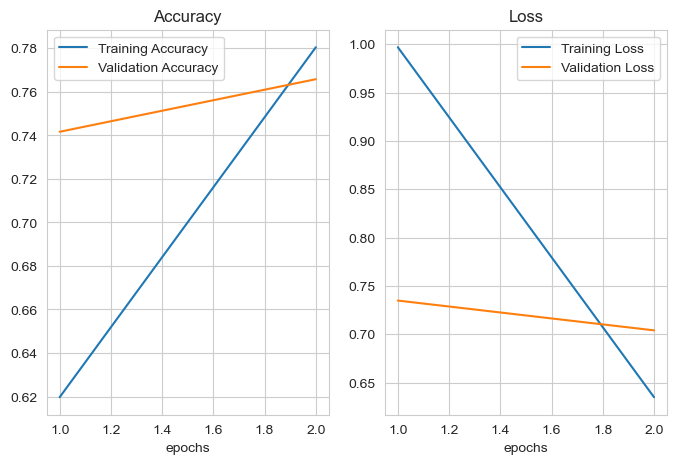

In [50]:
val_acc_viz(hist_2, EPOCHS)

## Предсказание модели

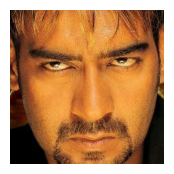

anger is anger (96.14%)


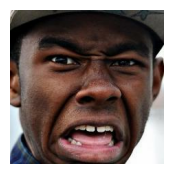

disgust is anger (56.38%)


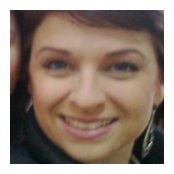

happiness is happiness (95.46%)


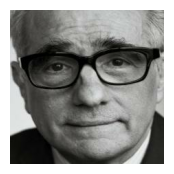

happiness is happiness (69.18%)


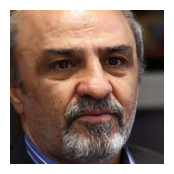

anger is happiness (35.94%)


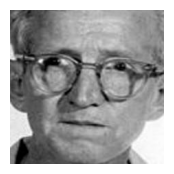

fear is anger (88.73%)


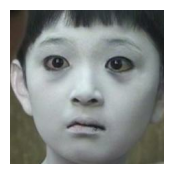

fear is fear (98.11%)


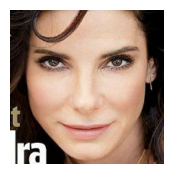

happiness is happiness (96.58%)


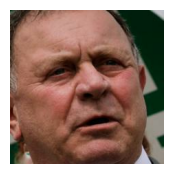

disgust is anger (57.49%)


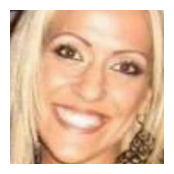

happiness is happiness (98.42%)


In [51]:
show_predictions(model_2)

## Матрица ошибок

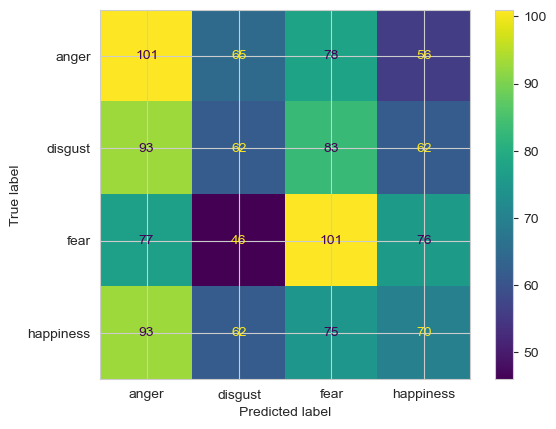

In [52]:
confusion_matrix(model_2)

# <b>Модель 3</b> | Data augmentation

## Модуль Hub | `feature_extractor_layer`

In [87]:
do_fine_tuning = False

In [88]:
feature_extractor = hub.KerasLayer(
                            MODULE_HANDLE,
                            # input_shape=IMAGE_SIZE + (3,),
                            output_shape=[FV_SIZE],
                            trainable=do_fine_tuning
)

## Архитектура модели

In [89]:
print('Building model with', MODULE_HANDLE)

model_3 = tf.keras.Sequential([
    
        rescale,
        data_aug,
    
        feature_extractor,
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    
])

model_3.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_9 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
__________________

In [90]:
if do_fine_tuning:
    model_3.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model_3.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## Обучение модели

In [92]:
EPOCHS = 2

hist_3 = model_3.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/2
300/300 [==============================] - 720s 2s/step - loss: 1.4620 - accuracy: 0.3689 - val_loss: 1.2725 - val_accuracy: 0.4183
Epoch 2/2
300/300 [==============================] - 678s 2s/step - loss: 1.2997 - accuracy: 0.4306 - val_loss: 1.2628 - val_accuracy: 0.4250


## Визуализация данных по работе алгоритма

Посмотрим на то, как вели себя функция потерь и `accuracy` на тренировочном и валидационном датасетах на всех итерациях нашей модели.

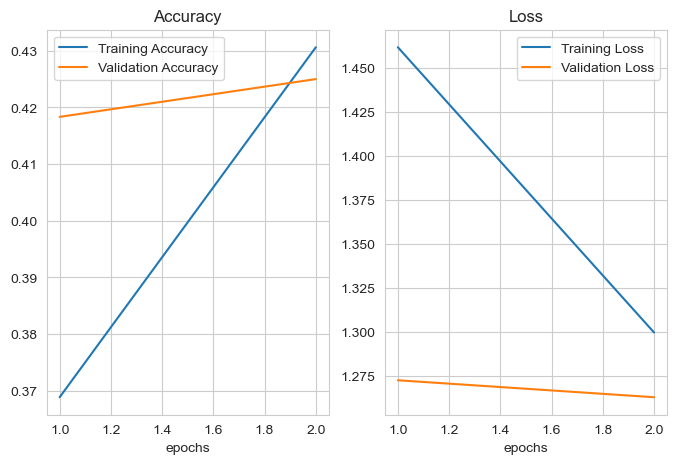

In [93]:
val_acc_viz(hist_3, EPOCHS)

## Предсказание модели

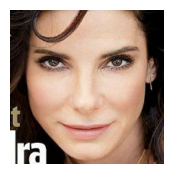

happiness is happiness (58.84%)


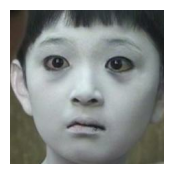

fear is happiness (31.31%)


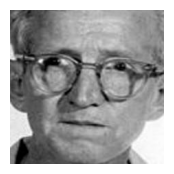

fear is anger (53.15%)


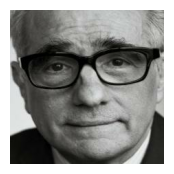

happiness is anger (36.88%)


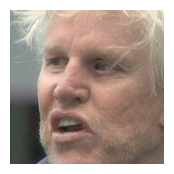

disgust is happiness (39.49%)


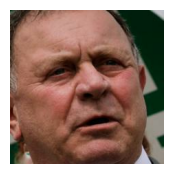

disgust is anger (55.73%)


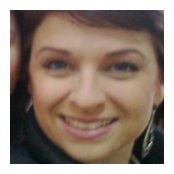

happiness is disgust (51.01%)


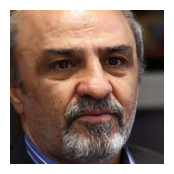

anger is anger (33.72%)


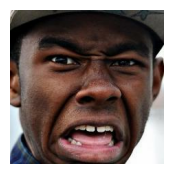

disgust is happiness (66.83%)


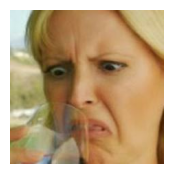

disgust is happiness (37.91%)


In [94]:
show_predictions(model_3)

## Матрица ошибок

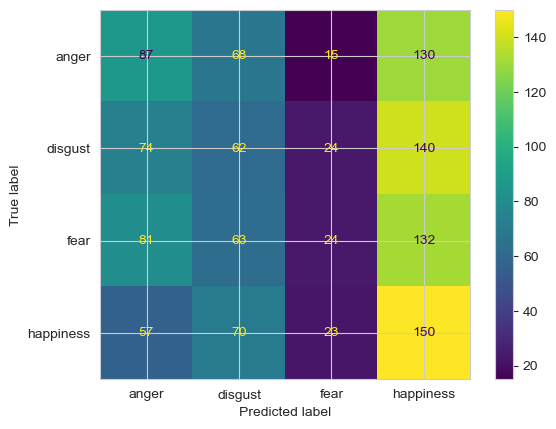

In [95]:
confusion_matrix(model_3)

# <b>Модель 4</b> | Больше слоев

## Модуль Hub | `feature_extractor_layer`

На этот раз попробуем обучить модель с 

In [96]:
do_fine_tuning = False

In [97]:
feature_extractor = hub.KerasLayer(
                            MODULE_HANDLE,
                            # input_shape=IMAGE_SIZE + (3,),
                            output_shape=[FV_SIZE],
                            trainable=do_fine_tuning
)

## Архитектура модели

In [98]:
print('Building model with', MODULE_HANDLE)

model_4 = tf.keras.Sequential([
    
        rescale,
        data_aug,
    
        feature_extractor,
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_4.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_10 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_10 (Dense)            (No

In [99]:
if do_fine_tuning:
    model_4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model_4.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## Обучение модели

In [100]:
EPOCHS = 1

hist_4 = model_4.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

300/300 [==============================] - 705s 2s/step - loss: 1.5609 - accuracy: 0.3683 - val_loss: 1.2684 - val_accuracy: 0.4225


## Визуализация данных по работе алгоритма

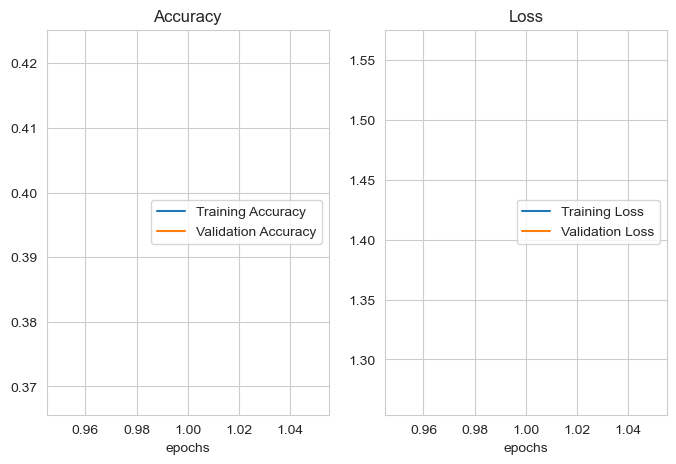

In [101]:
val_acc_viz(hist_4, EPOCHS)

## Предсказание модели

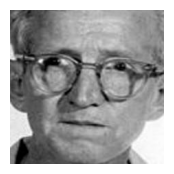

fear is anger (44.00%)


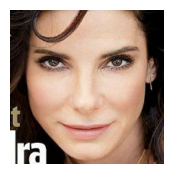

happiness is happiness (59.16%)


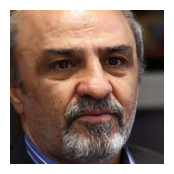

anger is anger (40.79%)


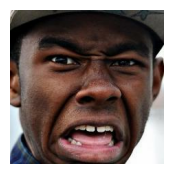

disgust is anger (41.02%)


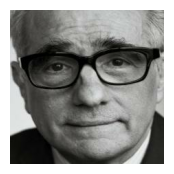

happiness is happiness (39.95%)


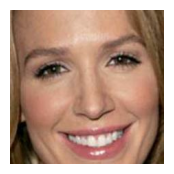

happiness is happiness (65.02%)


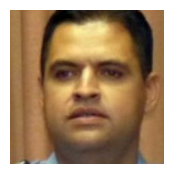

disgust is anger (40.92%)


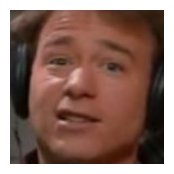

disgust is fear (49.02%)


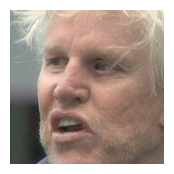

disgust is disgust (47.45%)


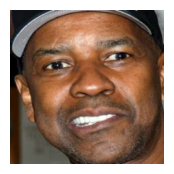

disgust is happiness (38.82%)


In [102]:
show_predictions(model_4)

## Матрица ошибок

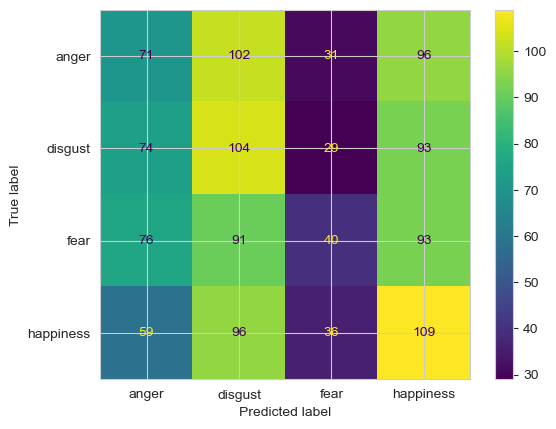

In [103]:
confusion_matrix(model_4)

# <b>Модель 5</b> | Больше слоев и trainable

## Модуль Hub | `feature_extractor_layer`

На этот раз попробуем обучить модель с 

In [104]:
do_fine_tuning = True

In [105]:
feature_extractor = hub.KerasLayer(
                            MODULE_HANDLE,
                            # input_shape=IMAGE_SIZE + (3,),
                            output_shape=[FV_SIZE],
                            trainable=do_fine_tuning
)

## Архитектура модели

In [110]:
print('Building model with', MODULE_HANDLE)

model_5 = tf.keras.Sequential([
    
        rescale,
        data_aug,
    
        feature_extractor,
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_5.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_11 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dropout_18 (Dropout)        (None, 1280)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_19 (Dense)            (No

In [111]:
if do_fine_tuning:
    model_5.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model_5.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## Обучение модели

In [112]:
EPOCHS = 1

hist_5 = model_5.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

300/300 [==============================] - 2865s 9s/step - loss: 1.5755 - accuracy: 0.3728 - val_loss: 1.2975 - val_accuracy: 0.4400


## Визуализация данных по работе алгоритма

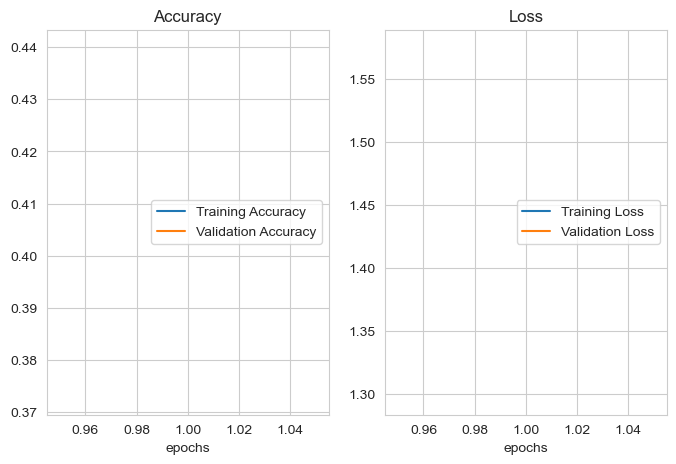

In [113]:
val_acc_viz(hist_5, EPOCHS)

## Предсказание модели

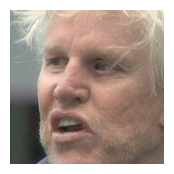

disgust is disgust (31.74%)


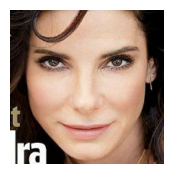

happiness is happiness (73.75%)


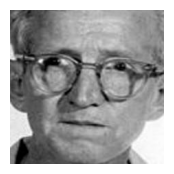

fear is anger (47.29%)


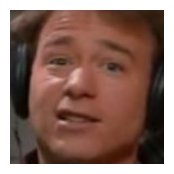

disgust is fear (45.57%)


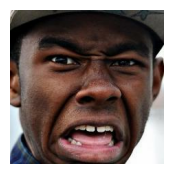

disgust is happiness (79.37%)


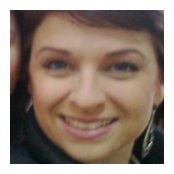

happiness is happiness (59.10%)


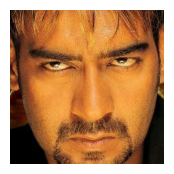

anger is happiness (33.71%)


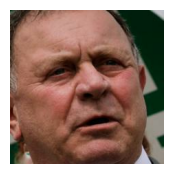

disgust is disgust (32.46%)


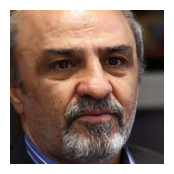

anger is anger (35.81%)


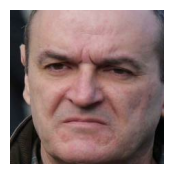

anger is anger (34.72%)


In [114]:
show_predictions(model_5)

## Матрица ошибок

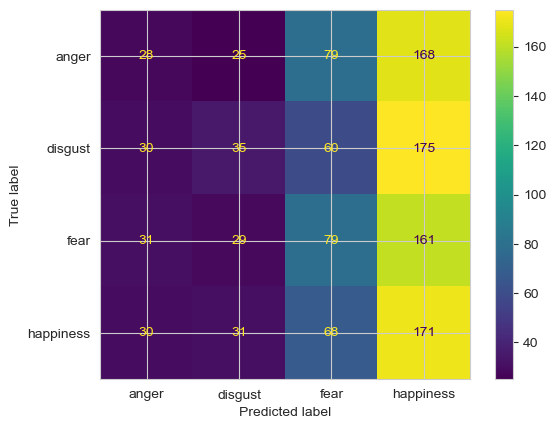

In [115]:
confusion_matrix(model_5)

# <b>Модель 6</b> | Свертка и разморозка слоев

Заметка.

В тф есть два способа переноса обучения:
- tensorflow-hub,
- tf.keras.applications.

Первый способ проще в имплементации, однако у него есть существенный недостаток - предобученная модель поставляется как единый слой и не подлежит частичной разморозке, разморозить можно только все слои зараз. Также два способа отличаются методом rescale - в первом случае изображения необходимо привести к стандарту [0, 1], тогда как во втором - [-1, 1]. Воспользуемся каждым способом в зависимости от того, каким образом мы хотим обучить нашу модель. 

## Модуль Hub | `feature_extractor_layer`

На этот раз попробуем обучить модель с 

In [300]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [301]:
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

feature_extractor.trainable = True

In [290]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))

Number of layers in the feature extractor:  154


In [302]:
# Fine-tune from this layer onwards
fine_tune_at = 149

# Freeze all the layers before the `fine_tune_at` layer
for layer in feature_extractor.layers[:fine_tune_at]:
    layer.trainable = False

In [292]:
image_batch, label_batch = next(iter(train_batches))
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [293]:
do_fine_tuning = True

In [294]:
# feature_extractor = hub.KerasLayer(
#                             MODULE_HANDLE,
#                             include_top=False,
#                             # input_shape=IMAGE_SIZE + (3,),
#                             output_shape=[FV_SIZE],
#                             trainable=do_fine_tuning
# )

In [296]:
# from tensorflow.keras import layers, callbacks

# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.001,  # minimium amount of change to count as an improvement
#     patience=6,  # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

## Архитектура модели

In [306]:
print('Building model with', MODULE_HANDLE)

model_6 = tf.keras.Sequential([
    
        rescale,
        data_aug,
    
        feature_extractor,
    
        tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=1, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
    
        tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=1, activation='relu'),
    
        tf.keras.layers.Flatten(),
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation='relu'),
    
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_6.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model_6.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 7, 32)          368672    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                

## Компиляция

In [307]:
if do_fine_tuning:
    model_6.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model_6.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## Обучение модели

In [308]:
EPOCHS = 10

hist_6 = model_6.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/10
35/35 [==============================] - 83s 2s/step - loss: 2.1411 - accuracy: 0.2287 - val_loss: 4.7174 - val_accuracy: 0.1618
Epoch 2/10
35/35 [==============================] - 78s 2s/step - loss: 1.8965 - accuracy: 0.2858 - val_loss: 5.0251 - val_accuracy: 0.2598
Epoch 3/10
35/35 [==============================] - 77s 2s/step - loss: 1.7262 - accuracy: 0.3348 - val_loss: 3.2256 - val_accuracy: 0.2451
Epoch 4/10
35/35 [==============================] - 77s 2s/step - loss: 1.6953 - accuracy: 0.3394 - val_loss: 3.1463 - val_accuracy: 0.1422
Epoch 5/10
35/35 [==============================] - 70s 2s/step - loss: 1.5282 - accuracy: 0.4156 - val_loss: 3.2083 - val_accuracy: 0.2010
Epoch 6/10
35/35 [==============================] - 68s 2s/step - loss: 1.4603 - accuracy: 0.4356 - val_loss: 4.4186 - val_accuracy: 0.1422
Epoch 7/10
35/35 [==============================] - 68s 2s/step - loss: 1.3807 - accuracy: 0.4982 - val_loss: 2.8516 - val_accuracy: 0.3186
Epoch 8/10
35/35 [==

Чем меньше слоев разморожено, тем быстрее наступает переобучение.

## Визуализация данных по работе алгоритма

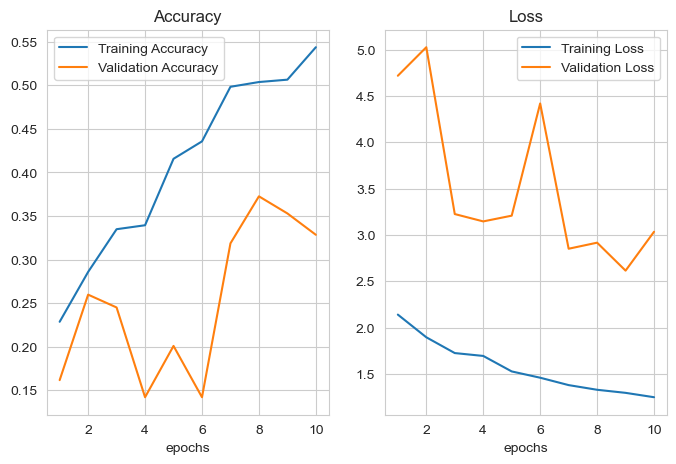

In [309]:
val_acc_viz(hist_6, EPOCHS)

## Предсказание модели

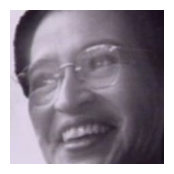

joyfulness is fear (68.13%)


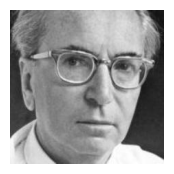

neutral is disgust (49.73%)


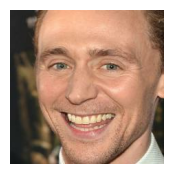

joyfulness is anger (36.26%)


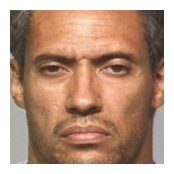

neutral is anger (42.10%)


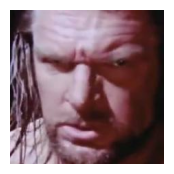

anger is disgust (57.17%)


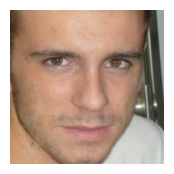

neutral is anger (49.56%)


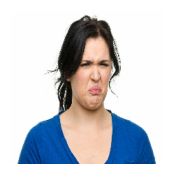

disgust is anger (45.03%)


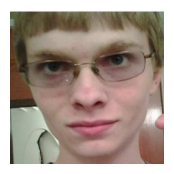

neutral is disgust (58.92%)


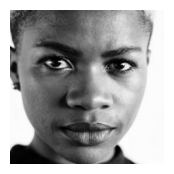

neutral is fear (47.71%)


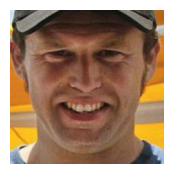

joyfulness is joyfulness (82.15%)


In [310]:
show_predictions(model_6)

## Матрица ошибок

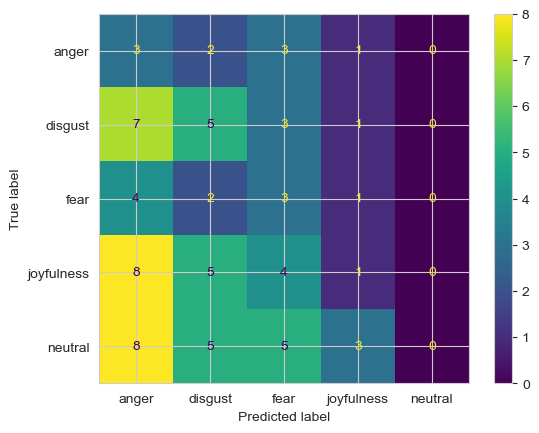

In [311]:
confusion_matrix(model_6)

# <b>Конвертация модели в формат `tflite`</b>

## Экспорт модели

In [255]:
EMOTIONS_SAVED_MODEL = "./saved/exp_saved_model"

In [40]:
tf.saved_model.save(model_5, EMOTIONS_SAVED_MODEL)

INFO:tensorflow:Assets written to: ./saved/exp_saved_model\assets


INFO:tensorflow:Assets written to: ./saved/exp_saved_model\assets


In [41]:
loaded = tf.saved_model.load(EMOTIONS_SAVED_MODEL)
loaded

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x19e7b0f08b0>

In [42]:
print(list(loaded.signatures.keys()))

['serving_default']


In [43]:
infer = loaded.signatures['serving_default']
infer

<ConcreteFunction signature_wrapper(*, sequential_input) at 0x19F404A66D0>

In [44]:
print(infer.structured_input_signature)

((), {'sequential_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='sequential_input')})


In [45]:
print(infer.structured_outputs)

{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


In [46]:
# EMOTIONS_SAVED_MODEL = "./saved/exp_saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(EMOTIONS_SAVED_MODEL)
converter

## Оптимизация сконвертированной модели

### Post-Training Quantization

In [47]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations

[<Optimize.DEFAULT: 'DEFAULT'>]

### Post-Training Integer Quantization

In [48]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

In [50]:
# работа оператора yield
def data_gen():
    for i in range(3):
        yield [i]
        
a = data_gen()
print(a)  # generator object

for j in a:
    print(j)

<generator object data_gen at 0x0000019E7AFB4E40>
[0]
[1]
[2]


In [53]:
converter.representative_dataset = representative_data_gen
converter.representative_dataset

<function __main__.representative_data_gen()>

### Full Integer Quantization

In [54]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_ops

[<OpsSet.TFLITE_BUILTINS_INT8: 'TFLITE_BUILTINS_INT8'>]

## Конвертация

In [57]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

## Проверка `tflite` модели с использованием  интерпретатора Python

### Загрузка облегченной модели и локализация тензоров

In [58]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [59]:
input_index

0

In [60]:
output_index

181

### Сбор данных из тестовой выборки для оценки результативности 

In [95]:
for img, label in test_batches.take(1):
    # print(img)
    print(label.numpy())

[[1.]]


In [205]:
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:26<00:00,  3.26s/it]


### Визуализация предсказания в виде изображения

In [171]:
# class_names = [name.lower() for name in classes]
# class_names

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], int(true_label[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)  # уменьшение размерности

    plt.imshow(img.astype('uint8'), cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

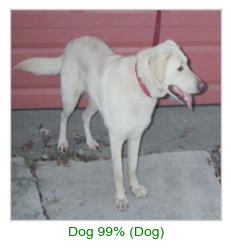

In [270]:
index = np.random.randint(10)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Сохраним также и названия классов.

In [272]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

# <b>Использованные источники и литература</b>

**Курсы**

1. Holbrook R. Intro to Deep Learning // https://www.kaggle.com/learn/intro-to-deep-learning
1. Moroney L. Device-based Models with TensorFlow Lite // https://www.coursera.org/learn/device-based-models-tensorflow

**Статьи**
1. Confusion Matrix // https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html 
1. gdown // https://pypi.org/project/gdown/
1. Load and preprocess images // https://www.tensorflow.org/tutorials/load_data/images
1. Module: tf.data.Dataset // https://www.tensorflow.org/api_docs/python/tf/data/Dataset
1. Module: tf.keras.applications.mobilenet_v2 // https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v
1. Tensorflow Hub // https://www.tensorflow.org/hub
1. Transfer learning and fine-tuning // https://www.tensorflow.org/tutorials/images/transfer_learning
1. Transfer learning and fine-tuning // https://keras.io/guides/transfer_learning/

**Форумы**
1. StackOverflow // https://stackoverflow.com/
1. GitHub // https://github.com/